In [1]:
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="50" alt="Gdrive-logo"/></center>
#@markdown <center><h3>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive! 
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


In [2]:
#@title Load Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import time
import copy
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from tqdm import tqdm
from PIL import Image
from google.colab import files
#!pip install kaggle

In [ ]:
#@title CPU Details - Number & Model
!lscpu | grep "CPU(s):"
!lscpu | grep Hz



CPU(s):              2
NUMA node0 CPU(s):   0,1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
CPU MHz:             2199.998


In [ ]:
#@title Total Memory:
!cat /proc/meminfo | grep MemTotal

MemTotal:       13302920 kB


In [ ]:
#@title CUDA Check
print('Is CUDA Available?',torch.cuda.is_available())
if torch.cuda.is_available() == True: print('Current CUDA device:',torch.cuda.get_device_name(0))

Is CUDA Available? True
Current CUDA device: Tesla T4


In [ ]:
dataset_home = '/content/drive/MyDrive/Style_Transfer_CCVAE/data/'
painter_labels = ['auguste-renoir/', 'claude-monet/', 'vincent-van-gogh/']

# Create train and val subdirectories
subdirs = ['train/', 'val/']
for subdir in subdirs:
	# create label subdirectories
	for labldir in painter_labels:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [ ]:
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories

for label in painter_labels:
  src_directory = dataset_home + label
  print('Copying images from', src_directory)

  for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
      dst_dir = 'val/'
    dst = dataset_home + dst_dir + label + file
    print(dst)
    copyfile(src, dst)


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
batch_size = 16
data_dir = dataset_home
print('data_dir = ', data_dir)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}

# Note: number of workers reduced from 4 to 2
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print(class_names) # => ['auguste-renoir', 'claude-monet', 'vincent-van-gogh']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

train_dataloader = torch.utils.data.DataLoader(image_datasets['train'],batch_size=batch_size,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(image_datasets['val'],batch_size=batch_size,shuffle=True)

data_dir =  /content/drive/MyDrive/Style_Transfer_CCVAE/data/
cuda:0
['auguste-renoir', 'claude-monet', 'vincent-van-gogh']
Train image size: 2929
Validation image size: 990


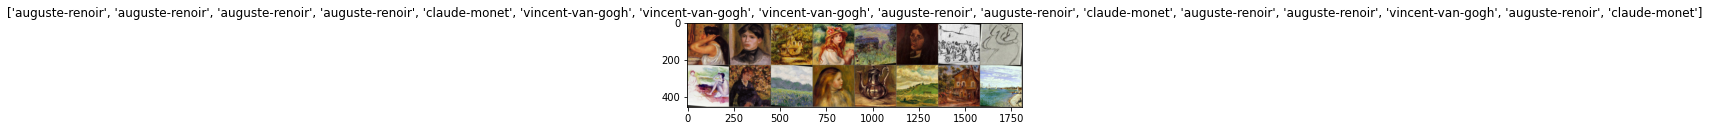

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print('original ResNet:')
print('in_features = ', model_ft.fc.in_features)
print('out_features = ', model_ft.fc.out_features)
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)
print('adjusted ResNet:')
print('in_features = ', model_ft.fc.in_features)
print('out_features = ', model_ft.fc.out_features)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



original ResNet:
in_features =  512
out_features =  1000
adjusted ResNet:
in_features =  512
out_features =  3


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1716 Acc: 0.9365
val Loss: 0.1442 Acc: 0.9485

Epoch 1/9
----------
train Loss: 0.1282 Acc: 0.9498
val Loss: 0.1580 Acc: 0.9394

Epoch 2/9
----------
train Loss: 0.0993 Acc: 0.9621
val Loss: 0.1718 Acc: 0.9424

Epoch 3/9
----------
train Loss: 0.0758 Acc: 0.9723
val Loss: 0.1376 Acc: 0.9535

Epoch 4/9
----------
train Loss: 0.0634 Acc: 0.9788
val Loss: 0.1615 Acc: 0.9465

Epoch 5/9
----------
train Loss: 0.0374 Acc: 0.9898
val Loss: 0.1626 Acc: 0.9424

Epoch 6/9
----------
train Loss: 0.0357 Acc: 0.9908
val Loss: 0.1278 Acc: 0.9576

Epoch 7/9
----------
train Loss: 0.0340 Acc: 0.9898
val Loss: 0.1346 Acc: 0.9545

Epoch 8/9
----------
train Loss: 0.0314 Acc: 0.9904
val Loss: 0.1320 Acc: 0.9515

Epoch 9/9
----------
train Loss: 0.0275 Acc: 0.9932
val Loss: 0.1426 Acc: 0.9525

Training complete in 19m 44s
Best val Acc: 0.957576


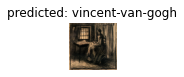

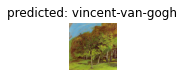

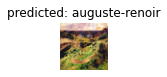

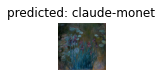

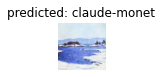

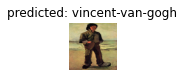

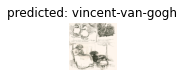

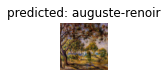

In [ ]:
visualize_model(model_ft)

In [ ]:
def process_image(image_path):

    #image = Image.open(image_path)
    image = image_path
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
from io import BytesIO
uploaded = files.upload()
im = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))
img_tensor = process_image(im)
img_tensor = img_tensor.view(1,3,224,224).cuda()
prediction = model_ft(img_tensor.to(device))
print("-------------------------------------")
print("Prediction of Category:",class_names[prediction.argmax()])
print("Probability is:",round(torch.nn.functional.softmax(prediction,dim=1).max().item()*100,2),"%")
print("-------------------------------------")
#Dog = 1, Cat = 0

In [ ]:
im_path = '/content/drive/MyDrive/Style_Transfer_CCVAE/data/val/claude-monet/claude-monet_alice-hoschede-in-the-garden(1).jpg'
print(im_path)
im = Image.open(im_path)

img_tensor = process_image(im)
img_tensor = img_tensor.view(1,3,224,224).cuda()
prediction = model_ft(img_tensor.to(device))

print("-------------------------------------")
print("Prediction of Category:",class_names[prediction.argmax()])
print("Probability is:",round(torch.nn.functional.softmax(prediction,dim=1).max().item()*100,2),"%")
print("-------------------------------------")

/content/drive/MyDrive/Style_Transfer_CCVAE/data/val/claude-monet/claude-monet_alice-hoschede-in-the-garden(1).jpg
-------------------------------------
Prediction of Category: claude-monet
Probability is: 99.41 %
-------------------------------------


In [ ]:
# Export the model
torch.save(model_ft, '/content/drive/MyDrive/Style_Transfer_CCVAE/model/painter_classifier_model_ResNet-18.pt')
#model = torch.load('filename.pt')